# Utilizando Elasticsearch com Python

## Importando o pacote cliente do Elasticsearch

Para instalar o pacote do Elasticsearch, use:

```
pip install elasticsearch
```

In [1]:
import json

import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import elasticsearch

client = elasticsearch.Elasticsearch('localhost:9200')

In [3]:
client.info()

{'name': 'elastic_node01',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'esd_btqvTTi7lyCc95hrwQ',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

# Queries Simples

A sintaxe da query é exatamente a mesma que vimos para a interface REST.

In [4]:
query = {
    "query": {
        "query_string": {
            "query": "enterprise Firefox"
        }
    }
}

results = client.search(index="kibana_sample_data_logs", body=query, _source=["message"], size=20)

In [5]:
print(f"Encontrado {results['hits']['total']['value']} resultados")

Encontrado 5741 resultados


In [6]:
for hit in results['hits']['hits']:
    print(hit['_source']['message'])

177.111.217.54 - - [2018-07-22T03:37:04.863Z] "GET /enterprise_1 HTTP/1.1" 200 2492 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322)"
177.111.217.54 - - [2018-07-22T03:37:04.863Z] "GET /enterprise HTTP/1.1" 200 2492 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322)"
63.238.199.177 - - [2018-07-22T15:52:07.797Z] "GET /enterprise HTTP/1.1" 503 0 "-" "Mozilla/5.0 (X11; Linux x86_64; rv:6.0a1) Gecko/20110421 Firefox/6.0a1"
65.60.20.207 - - [2018-07-22T21:48:16.637Z] "GET /enterprise HTTP/1.1" 200 8909 "-" "Mozilla/5.0 (X11; Linux x86_64; rv:6.0a1) Gecko/20110421 Firefox/6.0a1"
100.47.209.39 - - [2018-07-22T15:29:12.789Z] "GET /enterprise HTTP/1.1" 200 6942 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322)"
44.57.190.8 - - [2018-07-22T11:14:36.024Z] "GET /enterprise HTTP/1.1" 200 4064 "-" "Mozilla/5.0 (X11; Linux i686) AppleWebKit/534.24 (KHTML, like Gecko) Chrome/11.0.696.50 Safari/534.24"
168.207.24

## Agregaçoes Simples

Exemplo com Date Histogram

In [7]:
query = {
  "aggregations": {
    "msgs_por_dia": {
      "date_histogram": {
        "field": "@timestamp",
        "calendar_interval": "1h"
      }
    }
  },
  "query": {
    "range": {
      "@timestamp":{"gte": "2020-10-20", "lte": "2020-10-28"}}
  }
}

results = client.search(index="kibana_sample_data_logs", body=query, size=0)

In [8]:
buckets = results['aggregations']['msgs_por_dia']['buckets']

In [9]:
df_buckets = pd.DataFrame.from_records(buckets)
df_buckets['date'] = pd.to_datetime(df_buckets['key_as_string'])

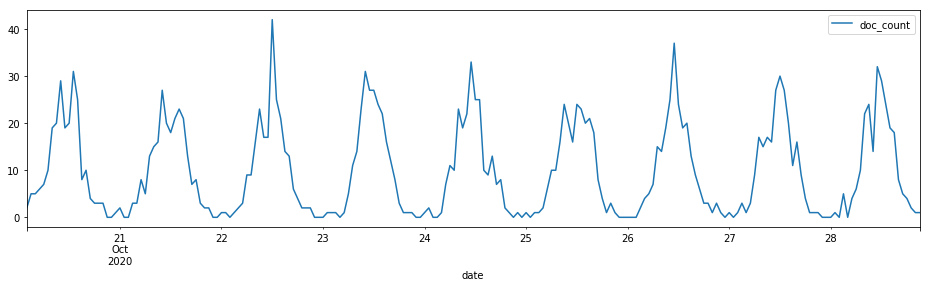

In [10]:
df_buckets.plot(x='date', y='doc_count', figsize=(16, 4))

## Exemplo com agregação aninhada

In [11]:
query = {
  "aggregations": {
    "msgs_por_dia": {
      "date_histogram": {
        "field": "@timestamp",
        "calendar_interval": "1h",
        
      },
      "aggregations": {
        "bytes": {
            "sum": {"field": "bytes"}
        }
      }
    }
  },
  "query": {
    "range": {
      "@timestamp":{"gte": "2020-10-20", "lte": "2020-10-28"}}
  }
}

results = client.search(index="kibana_sample_data_logs", body=query, size=0)

In [12]:
buckets = results['aggregations']['msgs_por_dia']['buckets']

In [13]:
df_buckets = pd.DataFrame.from_records({"key_as_string": x['key_as_string'], "bytes": x["bytes"]["value"]} for x in buckets)
df_buckets['date'] = pd.to_datetime(df_buckets['key_as_string'])

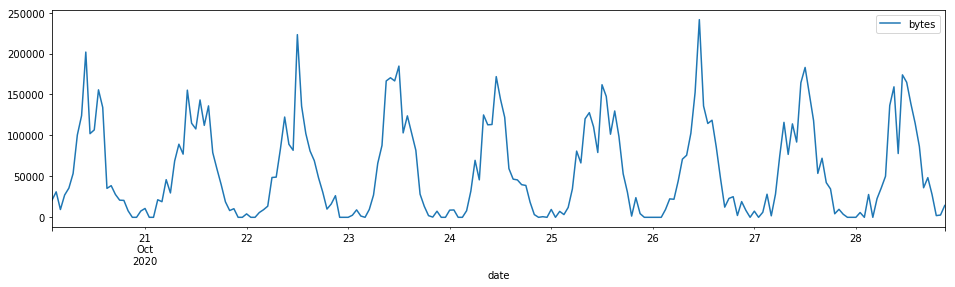

In [14]:
df_buckets.plot(x='date', y='bytes', figsize=(16, 4))

# Criando um índice especificando o mapping

In [15]:
# Apagar caso o indice exista
if client.indices.exists('20newsgroup_2'):
    client.indices.delete('20newsgroup_2')

In [16]:
mapping = {
    "settings": {
        "number_of_shards": 3
    },
    "mappings": {
        "properties": {
            "newsgroup": {
                "type": "text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "message": {
                "type": "text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                }
            }
        }
    }
}

In [17]:
client.indices.create('20newsgroup_2', body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': '20newsgroup_2'}

In [18]:
with open('20_newsgroup.ndjson','r') as fin:
    for line in fin:
        document = json.loads(line)
        client.index(index='20newsgroup_2', body=document)

# Agregação por termos no campo texto

In [19]:
from nltk.corpus import stopwords
# Executar somente da primeira vez, para baixar a lista de stopwords
#nltk.download('stopwords')

In [20]:
stopwords_en = stopwords.words('english')

stopwords_en += [
    'from', 'subject', 'lines', 'organization', 'nntp', 'posting', 'hosts',
    'writes', '[0-9]+','host', 'article', 'university', "i'm", "i've", 'would',
    'like', 'one', 'distribution', 'new', 'know', 'get', 'think', 'even', 'go',
    'say', 'many', 'time', 'want', 'much', 'us', 'people', 'good', 'could',
    'also', 'reply',
]

In [21]:
query = {
  "aggregations": {
    "termos": {
      "terms": {
        "field": "message",
        "size": 100,
        "exclude": "(" + "|".join(stopwords_en) + ")",
      }
    }
  },
  "query": {"match_all": {}},
  "size": 0
}

results = client.search(index="20newsgroup_2", body=query)

In [22]:
buckets = results['aggregations']['termos']['buckets']

## Plotando uma Wordcloud

In [23]:
# Para instalar esse pacote, execute:
# pip install wordcloud
import wordcloud

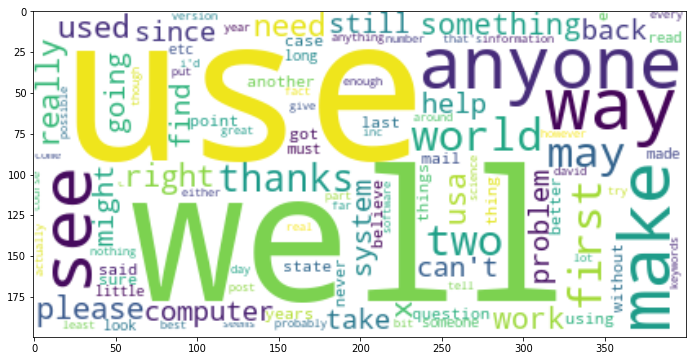

In [24]:
frequencies = {}
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color="white")

cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(cloud, interpolation='bilinear')

# Wordcloud para rec.autos

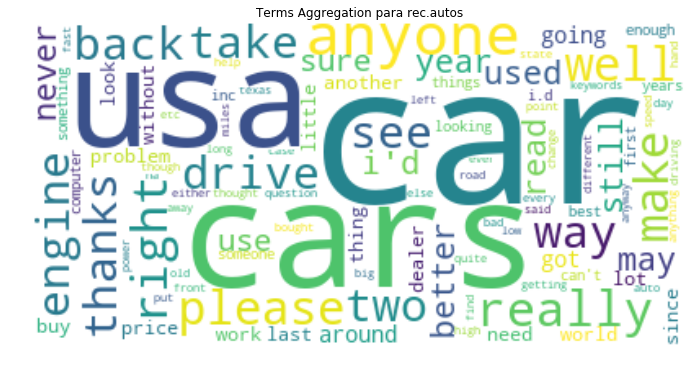

In [25]:
query = {
  "aggregations": {
    "termos": {
      "terms": {
        "field": "message",
        "size": 100,
        "exclude": "(" + "|".join(stopwords_en) + ")",
      }
    }
  },
  "query": {"term": {"newsgroup.raw": "rec.autos"}},
  "size": 0
}

results = client.search(index="20newsgroup_2", body=query)
buckets = results['aggregations']['termos']['buckets']
frequencies = {}
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color="white")

cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
_ = ax.set_title('Terms Aggregation para rec.autos')

## Wordcloud com Significant Terms

O Significant Terms busca selecionar palavras que mais diferenciam o conjunto de documentos selecionados do _background_. Portanto, deve retornar termos que são mais significativos para o subconjunto de documentos selecionado pela query.

Veja na [documentação do Significant Terms Aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-significantterms-aggregation.html) as diferentes formas de selecionar a importância das palavras.

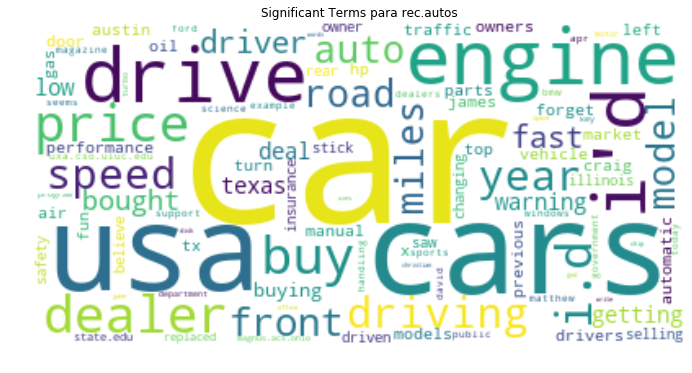

In [26]:
query = {
  "aggregations": {
    "termos": {
      "significant_terms": {
        "field": "message",
        "size": 100,
        "exclude": "(" + "|".join(stopwords_en) + ")",
        "mutual_information": {
          "include_negatives": True
         }
      }
    }
  },
  "query": {"term": {"newsgroup.raw": "rec.autos"}},
  "size": 0
}

results = client.search(index="20newsgroup_2", body=query)
buckets = results['aggregations']['termos']['buckets']
frequencies = {}
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color="white")

cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
_ = ax.set_title('Significant Terms para rec.autos')

## Significant Terms aggregation, mas para outro grupo

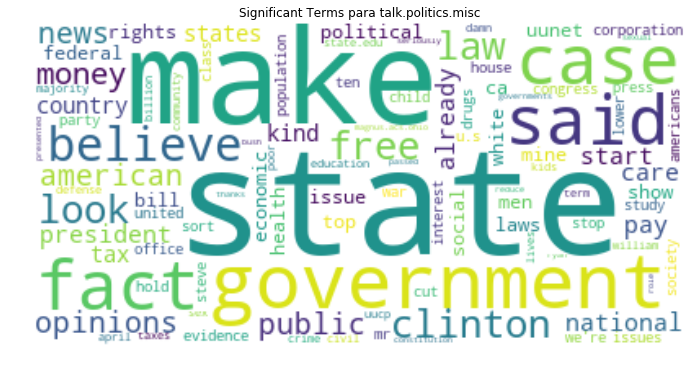

In [27]:
query = {
  "aggregations": {
    "termos": {
      "significant_terms": {
        "field": "message",
        "size": 100,
        "exclude": "(" + "|".join(stopwords_en) + ")",
          "mutual_information": {
          "include_negatives": True
         }
      }
    }
  },
  "query": {"term": {"newsgroup.raw": "talk.politics.misc"}},
  "size": 0
}

results = client.search(index="20newsgroup_2", body=query)
buckets = results['aggregations']['termos']['buckets']
frequencies = {}
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color="white")

cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16,6))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')
_ = ax.set_title('Significant Terms para talk.politics.misc')